In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=e6031c97fd2fc6836d119f31532ad14f6cf200ebbdf90ace0b4c050ed9295d97
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("Colab")\
        .getOrCreate()

In [ ]:
#  .master("local")\.config('spark.ui.port', '4050') \ (Configuring the Spark UI port in PySpark allows you to specify which port the Spark User Interface (UI) will listen on.
#The Spark UI is a web-based dashboard that provides valuable information and insights into the status and progress of your Spark application. ) http://localhost:4050

In [ ]:
spark

In [ ]:

df  = spark.read.csv("SM Cleaned Data BR Aggregated.csv", header=True, inferSchema=True)


In [ ]:
historical_data  = spark.read.csv("SM Cleaned Data BR Aggregated.csv", header=True, inferSchema=True)


In [ ]:
df.show()

+-----+----------+------------------+
|meter|      Date|             t_kWh|
+-----+----------+------------------+
| BR02|2019-07-10| 6.959999999999997|
| BR02|2019-07-11| 4.910999999999991|
| BR02|2019-07-13| 5.872999999999988|
| BR02|2019-07-14| 5.457999999999984|
| BR02|2019-07-15| 4.859999999999995|
| BR02|2019-07-16| 4.281999999999985|
| BR02|2019-07-17| 4.421999999999985|
| BR02|2019-07-18|  4.33699999999998|
| BR02|2019-07-19| 5.441999999999984|
| BR02|2019-07-20| 5.650999999999988|
| BR02|2019-07-30| 5.847999999999994|
| BR02|2019-07-31|5.8319999999999865|
| BR02|2019-08-01| 5.006999999999988|
| BR02|2019-08-04| 7.383999999999983|
| BR02|2019-08-05| 6.977999999999994|
| BR02|2019-08-06|5.2839999999999945|
| BR02|2019-08-07| 5.651999999999995|
| BR02|2019-08-08|4.7749999999999835|
| BR02|2019-08-09| 5.005999999999984|
| BR02|2019-08-10|5.8899999999999775|
+-----+----------+------------------+
only showing top 20 rows



In [ ]:
df = df.na.drop()

In [ ]:
df.count()

28119

In [ ]:
df.printSchema()


root
 |-- meter: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- t_kWh: double (nullable = true)



In [ ]:
df.describe().show()

+-------+-----+-----------------+
|summary|meter|            t_kWh|
+-------+-----+-----------------+
|  count|28119|            28119|
|   mean| NULL| 8.20758266652449|
| stddev| NULL|7.719020205928047|
|    min| BR02|              0.0|
|    max| BR52|82.62199999999989|
+-------+-----+-----------------+



In [ ]:
df.select("meter").distinct().show()

+-----+
|meter|
+-----+
| BR09|
| BR26|
| BR04|
| BR34|
| BR24|
| BR12|
| BR27|
| BR45|
| BR20|
| BR06|
| BR51|
| BR05|
| BR16|
| BR30|
| BR14|
| BR31|
| BR37|
| BR10|
| BR23|
| BR13|
+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import year, month, dayofweek

# Extract year, month, and day of the week as features
df = df.withColumn("Year", year("Date"))
df = df.withColumn("Month", month("Date"))
df = df.withColumn("DayOfWeek", dayofweek("Date"))

# Show the DataFrame with added time-based features
df.show()


+-----+----------+------------------+----+-----+---------+
|meter|      Date|             t_kWh|Year|Month|DayOfWeek|
+-----+----------+------------------+----+-----+---------+
| BR02|2019-07-10| 6.959999999999997|2019|    7|        4|
| BR02|2019-07-11| 4.910999999999991|2019|    7|        5|
| BR02|2019-07-13| 5.872999999999988|2019|    7|        7|
| BR02|2019-07-14| 5.457999999999984|2019|    7|        1|
| BR02|2019-07-15| 4.859999999999995|2019|    7|        2|
| BR02|2019-07-16| 4.281999999999985|2019|    7|        3|
| BR02|2019-07-17| 4.421999999999985|2019|    7|        4|
| BR02|2019-07-18|  4.33699999999998|2019|    7|        5|
| BR02|2019-07-19| 5.441999999999984|2019|    7|        6|
| BR02|2019-07-20| 5.650999999999988|2019|    7|        7|
| BR02|2019-07-30| 5.847999999999994|2019|    7|        3|
| BR02|2019-07-31|5.8319999999999865|2019|    7|        4|
| BR02|2019-08-01| 5.006999999999988|2019|    8|        5|
| BR02|2019-08-04| 7.383999999999983|2019|    8|        

 The dayofweek function is used to extract the day of the week (as an integer, where Sunday is 1 and Saturday is 7) from the "Date" column and populate the "DayOfWeek" column with these values.

In [ ]:
from pyspark.sql import functions as F
# Group by the "Year" column and aggregate the sum of "t_kWh"
yearly_aggregated = df.groupBy("Year").agg(F.sum("t_kWh").alias("Total_t_kWh"))

# Show the aggregated DataFrame
yearly_aggregated.show()

+----+------------------+
|Year|       Total_t_kWh|
+----+------------------+
|2019| 43295.06199999978|
|2020|110862.38499999988|
|2021| 76631.56999999995|
+----+------------------+



 functions module from PySpark as F. It allows you to use PySpark's built-in functions for data transformations and aggregations. aggregate the grouped data by calculating the sum of the "t_kWh" column for each group (i.e., for each year). The alias function is used to rename the resulting aggregation column to "Total_t_kWh

In [ ]:
# Group by "Year" and "Month" columns and aggregate the sum of "t_kWh"
yearly_monthly_aggregated = df.groupBy("Year", "Month").agg(F.sum("t_kWh").alias("Total_t_kWh"))

# Order by "Year" and then by "Month"
yearly_monthly_aggregated = yearly_monthly_aggregated.orderBy("Year", "Month")

# Get unique years from the DataFrame
years = yearly_monthly_aggregated.select("Year").distinct().rdd.flatMap(lambda x: x).collect()
#.rdd.flatMap(lambda x: x) is used to flatten the distinct values, which are stored in a DataFrame, into a flat list.

# Loop through each year and print the data for that year
for year in years:
    print(f"Year {year}:")
    yearly_data = yearly_monthly_aggregated.filter(yearly_monthly_aggregated["Year"] == year)
    yearly_data.show()

Year 2019:
+----+-----+------------------+
|Year|Month|       Total_t_kWh|
+----+-----+------------------+
|2019|    5| 308.6099999999997|
|2019|    6| 459.6659999999996|
|2019|    7| 3178.816999999997|
|2019|    8| 9876.701999999987|
|2019|    9|10708.592000000002|
|2019|   10| 7527.386999999978|
|2019|   11| 5262.442999999988|
|2019|   12|5972.8450000000075|
+----+-----+------------------+

Year 2020:
+----+-----+------------------+
|Year|Month|       Total_t_kWh|
+----+-----+------------------+
|2020|    1| 7041.726999999996|
|2020|    2| 5512.663999999983|
|2020|    3| 5704.185999999984|
|2020|    4| 8163.276999999987|
|2020|    5|10726.192999999985|
|2020|    6|14669.429999999977|
|2020|    7|         13810.638|
|2020|    8| 13476.67100000001|
|2020|    9| 11913.70399999998|
|2020|   10| 9022.416999999987|
|2020|   11| 4795.527999999992|
|2020|   12|6025.9499999999825|
+----+-----+------------------+

Year 2021:
+----+-----+------------------+
|Year|Month|       Total_t_kWh|
+----

In [ ]:

# Count and display the number of null values in each column
null_counts = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])
null_counts.show()

+-----+----+-----+----+-----+---------+
|meter|Date|t_kWh|Year|Month|DayOfWeek|
+-----+----+-----+----+-----+---------+
|    0|   0|    0|   0|    0|        0|
+-----+----+-----+----+-----+---------+



In [ ]:

(df.count() , len(df.columns))

(28119, 6)

The StringIndexer is used to convert categorical or string values into numerical labels. The OneHotEncoder is used to convert categorical values, which have been indexed by the StringIndexer or other methods, into a binary vector (0 or 1) representation.
Original Categorical Data:

"Color": ["Red", "Green", "Blue", "Red", "Blue"]
After StringIndexer (assigning unique numerical labels):

"ColorIndex": [0, 1, 2, 0, 2]
After OneHotEncoder (creating binary vectors):

"ColorVector": [ [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 0, 1] ]

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# Create StringIndexer objects for your columns
SI_meter = StringIndexer(inputCol='meter', outputCol='meter_indexed')

# Transform the data
df = SI_meter.fit(df).transform(df)

# View the transformed data
df.select('meter', 'meter_indexed').show(10)

+-----+-------------+
|meter|meter_indexed|
+-----+-------------+
| BR02|         37.0|
| BR02|         37.0|
| BR02|         37.0|
| BR02|         37.0|
| BR02|         37.0|
| BR02|         37.0|
| BR02|         37.0|
| BR02|         37.0|
| BR02|         37.0|
| BR02|         37.0|
+-----+-------------+
only showing top 10 rows



In [ ]:
df.show()

+-----+----------+------------------+----+-----+---------+-------------+
|meter|      Date|             t_kWh|Year|Month|DayOfWeek|meter_indexed|
+-----+----------+------------------+----+-----+---------+-------------+
| BR02|2019-07-10| 6.959999999999997|2019|    7|        4|         37.0|
| BR02|2019-07-11| 4.910999999999991|2019|    7|        5|         37.0|
| BR02|2019-07-13| 5.872999999999988|2019|    7|        7|         37.0|
| BR02|2019-07-14| 5.457999999999984|2019|    7|        1|         37.0|
| BR02|2019-07-15| 4.859999999999995|2019|    7|        2|         37.0|
| BR02|2019-07-16| 4.281999999999985|2019|    7|        3|         37.0|
| BR02|2019-07-17| 4.421999999999985|2019|    7|        4|         37.0|
| BR02|2019-07-18|  4.33699999999998|2019|    7|        5|         37.0|
| BR02|2019-07-19| 5.441999999999984|2019|    7|        6|         37.0|
| BR02|2019-07-20| 5.650999999999988|2019|    7|        7|         37.0|
| BR02|2019-07-30| 5.847999999999994|2019|    7|   

PySpark's VectorAssembler to combine multiple feature columns into a single feature vector and then applying the StandardScaler to scale these features. The resulting DataFrame final_data contains the original columns along with the newly created "features" column, which holds the feature vectors.

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# List of input feature columns for the assembler
input_cols = ['Year', 'Month', 'DayOfWeek', 'meter_indexed']

# Create the VectorAssembler
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Transform the data to create the feature vector
final_data = assembler.transform(df)

# View the transformed feature vector
final_data.select('features').show()

+--------------------+
|            features|
+--------------------+
|[2019.0,7.0,4.0,3...|
|[2019.0,7.0,5.0,3...|
|[2019.0,7.0,7.0,3...|
|[2019.0,7.0,1.0,3...|
|[2019.0,7.0,2.0,3...|
|[2019.0,7.0,3.0,3...|
|[2019.0,7.0,4.0,3...|
|[2019.0,7.0,5.0,3...|
|[2019.0,7.0,6.0,3...|
|[2019.0,7.0,7.0,3...|
|[2019.0,7.0,3.0,3...|
|[2019.0,7.0,4.0,3...|
|[2019.0,8.0,5.0,3...|
|[2019.0,8.0,1.0,3...|
|[2019.0,8.0,2.0,3...|
|[2019.0,8.0,3.0,3...|
|[2019.0,8.0,4.0,3...|
|[2019.0,8.0,5.0,3...|
|[2019.0,8.0,6.0,3...|
|[2019.0,8.0,7.0,3...|
+--------------------+
only showing top 20 rows



In [ ]:
df.write.csv("/content//preprocessed_data")

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag  # Import the lag function

# Define a window specification for ordering the data by Date
window_spec = Window.partitionBy("meter").orderBy("Date")

# Add a lag column to calculate the difference in t_kWh between consecutive dates
historical_data = historical_data.withColumn("t_kWh_lag", lag("t_kWh").over(window_spec))

# Calculate the difference in t_kWh between consecutive dates
historical_data = historical_data.withColumn("t_kWh_diff", col("t_kWh") - col("t_kWh_lag"))

# Show the DataFrame with the lag and difference columns
historical_data.show()

+-----+----------+------------------+------------------+--------------------+
|meter|      Date|             t_kWh|         t_kWh_lag|          t_kWh_diff|
+-----+----------+------------------+------------------+--------------------+
| BR02|2019-07-10| 6.959999999999997|              NULL|                NULL|
| BR02|2019-07-11| 4.910999999999991| 6.959999999999997| -2.0490000000000066|
| BR02|2019-07-13| 5.872999999999988| 4.910999999999991|  0.9619999999999971|
| BR02|2019-07-14| 5.457999999999984| 5.872999999999988| -0.4150000000000036|
| BR02|2019-07-15| 4.859999999999995| 5.457999999999984| -0.5979999999999892|
| BR02|2019-07-16| 4.281999999999985| 4.859999999999995| -0.5780000000000101|
| BR02|2019-07-17| 4.421999999999985| 4.281999999999985| 0.13999999999999968|
| BR02|2019-07-18|  4.33699999999998| 4.421999999999985| -0.0850000000000044|
| BR02|2019-07-19| 5.441999999999984|  4.33699999999998|   1.105000000000004|
| BR02|2019-07-20| 5.650999999999988| 5.441999999999984| 0.20900

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression

In [ ]:
bareilly2020= spark.read.csv("/content/CEEW - Smart meter data Bareilly 2020.csv", header=True, inferSchema=True)

In [ ]:
mh_aggr= spark.read.csv("/content/SM Cleaned Data MH Aggregated.csv", header=True, inferSchema=True)

In [ ]:
bareilly2020.show()

+-------------------+-----+--------------------+-------------------+-----------+-----+
|        x_Timestamp|t_kWh|z_Avg Voltage (Volt)|z_Avg Current (Amp)|y_Freq (Hz)|meter|
+-------------------+-----+--------------------+-------------------+-----------+-----+
|2020-01-01 00:00:00|0.002|              251.26|               0.15|      49.97| BR02|
|2020-01-01 00:03:00|0.001|              251.23|               0.15|      49.94| BR02|
|2020-01-01 00:06:00|0.001|              251.55|               0.14|      49.94| BR02|
|2020-01-01 00:09:00|0.001|              251.97|               0.14|      50.09| BR02|
|2020-01-01 00:12:00|0.002|              252.03|               0.14|      50.08| BR02|
|2020-01-01 00:15:00|0.001|              251.78|               0.14|       50.0| BR02|
|2020-01-01 00:18:00|0.001|              251.75|               0.13|      49.97| BR02|
|2020-01-01 00:21:00|0.001|              251.95|               0.14|       50.0| BR02|
|2020-01-01 00:24:00|0.002|              25

In [ ]:
mh_aggr.show()

+-----+----------+------------------+
|meter|      Date|             t_kWh|
+-----+----------+------------------+
| MH01|2019-05-01| 5.251999999999993|
| MH01|2019-05-02| 4.769999999999991|
| MH01|2019-05-03| 5.168999999999989|
| MH01|2019-05-04| 5.409999999999985|
| MH01|2019-05-05| 6.687999999999989|
| MH01|2019-05-06| 4.576999999999985|
| MH01|2019-05-07|4.6139999999999946|
| MH01|2019-05-08| 6.325999999999978|
| MH01|2019-05-09| 5.319999999999985|
| MH01|2019-05-10| 5.591999999999995|
| MH01|2019-05-11| 6.253999999999981|
| MH01|2019-05-12| 5.568999999999966|
| MH01|2019-05-13| 5.177999999999989|
| MH01|2019-05-14| 4.852999999999985|
| MH01|2019-05-15| 4.571999999999988|
| MH01|2019-05-16| 3.712999999999984|
| MH01|2019-05-17| 4.822999999999984|
| MH01|2019-05-18|3.6519999999999926|
| MH01|2019-05-19| 5.414999999999993|
| MH01|2019-05-20|5.1029999999999776|
+-----+----------+------------------+
only showing top 20 rows



In [ ]:
# Calculate average, minimum, maximum, and other descriptive statistics
descriptive_stats = bareilly2020.describe()

# Show the descriptive statistics
descriptive_stats.show()

+-------+--------------------+--------------------+-------------------+------------------+------+
|summary|               t_kWh|z_Avg Voltage (Volt)|z_Avg Current (Amp)|       y_Freq (Hz)| meter|
+-------+--------------------+--------------------+-------------------+------------------+------+
|  count|              213423|              213423|             213423|            213423|213423|
|   mean|0.012150330564178231|  235.05327776294777|  1.212646247124035|47.658409871461636|  NULL|
| stddev|0.013913193542496973|   52.78063528085287| 1.2609885415554853|10.576343693161457|  NULL|
|    min|                 0.0|                 0.0|                0.0|               0.0|  BR02|
|    max|               0.172|              296.12|              14.23|            208.33|  BR04|
+-------+--------------------+--------------------+-------------------+------------------+------+



In [ ]:


# Convert the 'x_Timestamp' column to a timestamp type
bareilly2020 = bareilly2020.withColumn('x_Timestamp', col('x_Timestamp').cast('timestamp'))

# Extract date and time-related features
bareilly2020 = bareilly2020.withColumn('Year', F.year('x_Timestamp'))
bareilly2020 = bareilly2020.withColumn('Month', F.month('x_Timestamp'))
bareilly2020 = bareilly2020.withColumn('Day', F.dayofmonth('x_Timestamp'))
bareilly2020 = bareilly2020.withColumn('Hour', F.hour('x_Timestamp'))
bareilly2020 = bareilly2020.withColumn('Minute', F.minute('x_Timestamp'))
bareilly2020 = bareilly2020.withColumn('Second', F.second('x_Timestamp'))

# Define a window specification for ordering the data by timestamp
window_spec = Window.partitionBy("meter").orderBy("x_Timestamp")

# Add a lag column to calculate the difference in t_kWh between consecutive timestamps
bareilly2020 = bareilly2020.withColumn("t_kWh_lag", F.lag("t_kWh").over(window_spec))

# Calculate the difference in t_kWh between consecutive timestamps
bareilly2020 = bareilly2020.withColumn("t_kWh_diff", col("t_kWh") - col("t_kWh_lag"))

# Show the DataFrame with the added date, time, and difference columns
bareilly2020.show()

+-------------------+-----+--------------------+-------------------+-----------+-----+----+-----+---+----+------+------+---------+----------+
|        x_Timestamp|t_kWh|z_Avg Voltage (Volt)|z_Avg Current (Amp)|y_Freq (Hz)|meter|Year|Month|Day|Hour|Minute|Second|t_kWh_lag|t_kWh_diff|
+-------------------+-----+--------------------+-------------------+-----------+-----+----+-----+---+----+------+------+---------+----------+
|2020-01-01 00:00:00|0.002|              251.26|               0.15|      49.97| BR02|2020|    1|  1|   0|     0|     0|     NULL|      NULL|
|2020-01-01 00:03:00|0.001|              251.23|               0.15|      49.94| BR02|2020|    1|  1|   0|     3|     0|    0.002|    -0.001|
|2020-01-01 00:06:00|0.001|              251.55|               0.14|      49.94| BR02|2020|    1|  1|   0|     6|     0|    0.001|       0.0|
|2020-01-01 00:09:00|0.001|              251.97|               0.14|      50.09| BR02|2020|    1|  1|   0|     9|     0|    0.001|       0.0|
|2020-

In [ ]:
# Convert the 'x_Timestamp' column to a date type
bareilly2020 = bareilly2020.withColumn('x_Date', F.to_date('x_Timestamp'))

# Group by 'x_Date' and perform the aggregations
daily_aggregations = bareilly2020.groupBy('x_Date').agg(
    F.sum('t_kWh').alias('Total_t_kWh'),
    F.avg('z_Avg Voltage (Volt)').alias('Avg_Voltage'),
    F.avg('z_Avg Current (Amp)').alias('Avg_Current')
)
# Order the DataFrame by 'x_Date'
daily_aggregations = daily_aggregations.orderBy('x_Date')

# Show the daily aggregations
daily_aggregations.show()


+----------+------------------+------------------+-------------------+
|    x_Date|       Total_t_kWh|       Avg_Voltage|        Avg_Current|
+----------+------------------+------------------+-------------------+
|2020-01-01|23.025000000000016|239.33704166666683| 1.4080486111111115|
|2020-01-02|15.314999999999932|189.75137500000008| 0.9783888888888898|
|2020-01-03| 14.22399999999993|243.98145138888898| 0.9267222222222219|
|2020-01-04|14.499999999999968| 245.8882708333335|  1.395093750000003|
|2020-01-05|14.901999999999976|247.45861458333346|  1.420624999999998|
|2020-01-06|14.195999999999927| 241.3736597222219| 0.9703055555555548|
|2020-01-07| 17.21099999999994|244.87427083333375|  1.078777777777778|
|2020-01-08|11.620999999999915|233.65676388888872| 0.7782430555555563|
|2020-01-10| 7.711999999999995|224.90322916666665|  1.415270833333333|
|2020-01-11|18.529000000000014|241.62161458333333| 1.7231562500000004|
|2020-01-12|            17.883| 257.5728541666667| 3.1107291666666645|
|2020-

In [ ]:

# Extract the month from the 'x_Date' column
daily_aggregations = daily_aggregations.withColumn('Month', F.month('x_Date'))

# Calculate the maximum and minimum 'Total_t_kWh' for each month
monthly_peak_lowest = daily_aggregations.groupBy('Month').agg(
    F.max('Total_t_kWh').alias('Peak_Total_t_kWh'),
    F.min('Total_t_kWh').alias('Lowest_Total_t_kWh'),
    F.first('x_Date', ignorenulls=True).alias('Peak_Total_t_kWh_Date'),
    F.last('x_Date', ignorenulls=True).alias('Lowest_Total_t_kWh_Date')
)
# Order the results by the 'Month' column in ascending order
monthly_peak_lowest = monthly_peak_lowest.orderBy('Month')

# Show the DataFrame with peak and lowest 'Total_t_kWh' for each month
monthly_peak_lowest.show()

+-----+------------------+------------------+---------------------+-----------------------+
|Month|  Peak_Total_t_kWh|Lowest_Total_t_kWh|Peak_Total_t_kWh_Date|Lowest_Total_t_kWh_Date|
+-----+------------------+------------------+---------------------+-----------------------+
|    1|23.025000000000016|0.5510000000000004|           2020-01-01|             2020-01-31|
|    2|15.287000000000008| 4.252999999999972|           2020-02-01|             2020-02-29|
|    3| 15.53299999999991| 5.849999999999981|           2020-03-01|             2020-03-31|
|    4|            18.044| 4.203999999999993|           2020-04-01|             2020-04-23|
|    5|15.037999999999972| 7.390999999999981|           2020-05-01|             2020-05-31|
|    6|20.617999999999963| 7.312999999999973|           2020-06-01|             2020-06-12|
|    7| 18.81999999999997| 6.853999999999989|           2020-07-16|             2020-07-29|
|    8| 18.78399999999986| 7.197999999999989|           2020-08-11|             

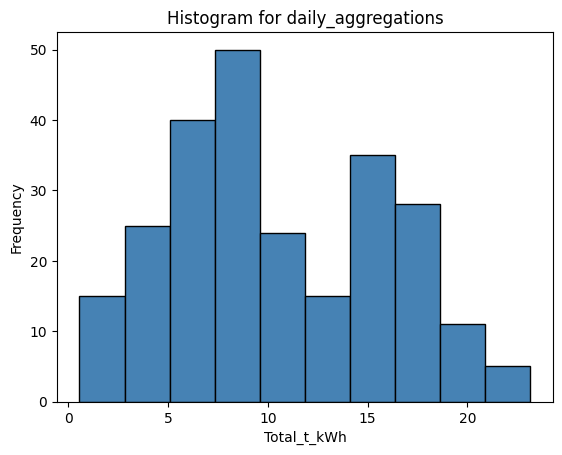

In [ ]:
# Assuming you have a DataFrame 'daily_aggregations' with a column named 'Total_t_kWh'
data = np.array(daily_aggregations.select("Total_t_kWh").rdd.flatMap(lambda x: x).collect())

# Create a histogram
plt.hist(data, bins=10, color="steelblue", edgecolor="black")

# Set labels and title
plt.xlabel("Total_t_kWh")
plt.ylabel("Frequency")
plt.title("Histogram for daily_aggregations")

# Show the plot
plt.show()



In [ ]:


# Perform monthly aggregation
monthly_aggregation = df.groupBy("Year", "Month").agg({"t_kWh": "sum"}).withColumnRenamed("sum(t_kWh)", "Monthly_t_kWh")

# Order the DataFrame by year and month
monthly_aggregation = monthly_aggregation.orderBy("Year", "Month")

# Show the ordered monthly aggregation
monthly_aggregation.show()


+----+-----+------------------+
|Year|Month|     Monthly_t_kWh|
+----+-----+------------------+
|2019|    5| 308.6099999999997|
|2019|    6| 459.6659999999996|
|2019|    7| 3178.816999999997|
|2019|    8| 9876.701999999987|
|2019|    9|10708.592000000002|
|2019|   10| 7527.386999999978|
|2019|   11| 5262.442999999988|
|2019|   12|5972.8450000000075|
|2020|    1| 7041.726999999996|
|2020|    2| 5512.663999999983|
|2020|    3| 5704.185999999984|
|2020|    4| 8163.276999999987|
|2020|    5|10726.192999999985|
|2020|    6|14669.429999999977|
|2020|    7|         13810.638|
|2020|    8| 13476.67100000001|
|2020|    9| 11913.70399999998|
|2020|   10| 9022.416999999987|
|2020|   11| 4795.527999999992|
|2020|   12|6025.9499999999825|
+----+-----+------------------+
only showing top 20 rows



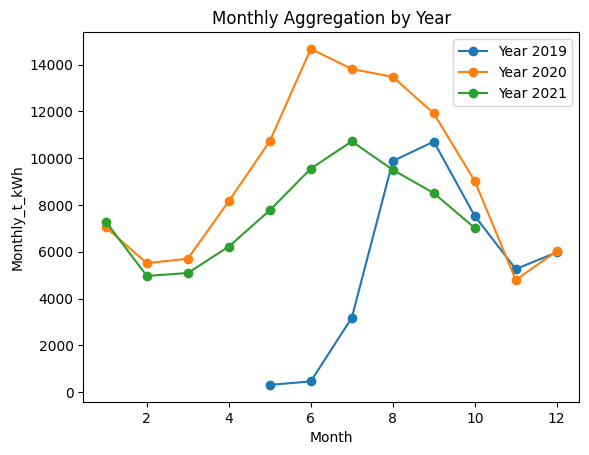

In [ ]:
# Plot the Monthly_t_kWh by month for each year using a scatter line graph
unique_years = [row["Year"] for row in monthly_aggregation.select("Year").distinct().collect()]

for year in unique_years:
    data = np.array(monthly_aggregation.filter(monthly_aggregation["Year"] == year)
                  .select("Month", "Monthly_t_kWh").orderBy("Month")
                  .rdd.flatMap(lambda x: x).collect())

    # Extract 'Month' and 'Monthly_t_kWh' values for the current year
    months = data[::2]
    t_kWh_values = data[1::2]

    # Create a scatter line graph
    plt.plot(months, t_kWh_values, label=f"Year {year}", marker='o', linestyle='-')

# Set labels and title
plt.xlabel("Month")
plt.ylabel("Monthly_t_kWh")
plt.title("Monthly Aggregation by Year")

# Add a legend to differentiate years
plt.legend()

# Show the plot
plt.show()


In PySpark, a pipeline is a powerful feature that allows you to streamline and automate the workflow for building and deploying machine learning models. It combines multiple stages, such as data preprocessing, feature engineering, and model training, into a single, reusable, and efficient process. Pipelines help ensure consistency, simplify code, and make it easier to manage the end-to-end machine learning process.

In [ ]:
#trying to create a pipeline

In [ ]:
# Split Data into Training and Testing Sets
(training_data, testing_data) = historical_data.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

Root Mean Squared Error (RMSE): 7.398608967227406


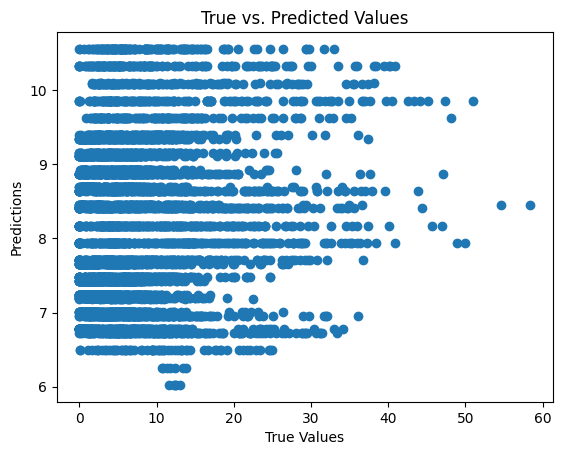

In [ ]:
# Prepare the data
assembler = VectorAssembler(inputCols=["Year", "Month", "DayOfWeek"], outputCol="features")
# df = assembler.transform(df)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Train a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="t_kWh")
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Calculate accuracy (for regression, commonly use RMSE)
evaluator = RegressionEvaluator(labelCol="t_kWh", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Optionally, create plots
plt.scatter(predictions.select("t_kWh").collect(), predictions.select("prediction").collect())
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs. Predicted Values")
plt.show()

In [ ]:
# Get the true values and predicted values
true_values = predictions.select("t_kWh").collect()
predicted_values = predictions.select("prediction").collect()


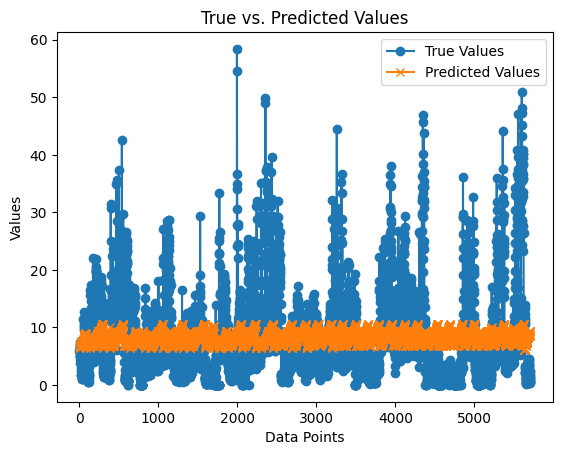

In [ ]:
#Create a line plot
plt.plot(true_values, label="True Values", marker='o')
plt.plot(predicted_values, label="Predicted Values", marker='x')

# Add labels and a legend
plt.xlabel("Data Points")
plt.ylabel("Values")
plt.title("True vs. Predicted Values")
plt.legend()

# Show the plot
plt.show()

In [ ]:
import seaborn as sns


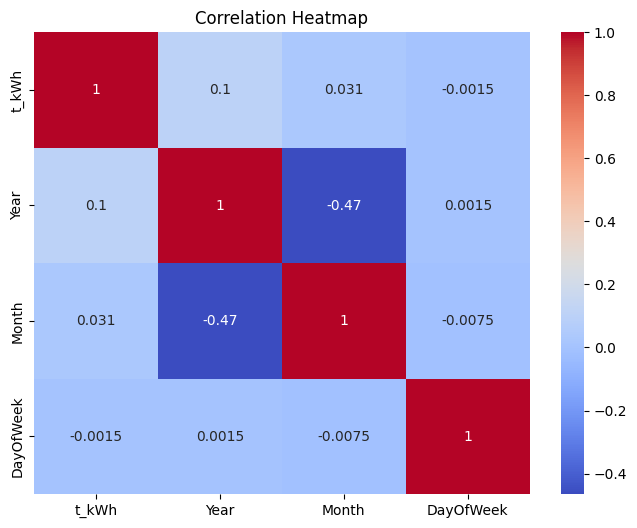

In [ ]:

# Create a heatmap of the data
correlation_matrix = df.select("t_kWh", "Year", "Month", "DayOfWeek").toPandas().corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()